In [70]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

In [71]:
# Load dataset
df = pd.read_csv('warehouse_temperature_humidity_2023.csv')

In [72]:
df['Failure'].value_counts()

0    6184
1    2576
Name: Failure, dtype: int64

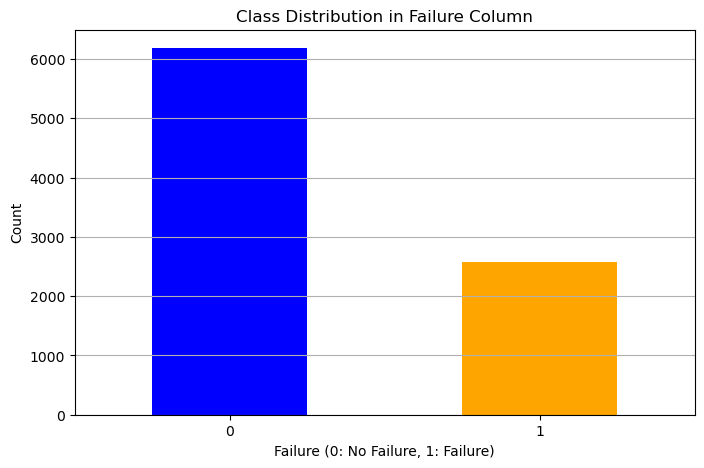

In [73]:
import matplotlib.pyplot as plt

# Create a bar plot for the counts of each class in the 'Failure' column
counts = df['Failure'].value_counts()

plt.figure(figsize=(8, 5))
counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution in Failure Column')
plt.xlabel('Failure (0: No Failure, 1: Failure)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


In [74]:
df.head()

,Timestamp,Temperature,Humidity,HVAC_Status,Failure
0,2023-01-01 00:00:00,13.292200,30.721027,off,0
1,2023-01-01 01:00:00,23.276265,26.168114,on,0
2,2023-01-01 02:00:00,11.254413,75.956148,on,0
3,2023-01-01 03:00:00,24.042563,69.492602,off,0
4,2023-01-01 04:00:00,17.353710,39.392427,off,0


In [75]:
#convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

#Convert HVAC_Status to numric
df['HVAC_Status'] = df['HVAC_Status'].apply(lambda x: 1 if x == 'on' else 0)

In [76]:
# Outlier removal using the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [77]:
# Remove outliers from Temperature and Humidity columns
df = remove_outliers(df, 'Temperature')
df = remove_outliers(df, 'Humidity')

In [78]:
df.head()

,Timestamp,Temperature,Humidity,HVAC_Status,Failure
0,2023-01-01 00:00:00,13.292200,30.721027,0,0
1,2023-01-01 01:00:00,23.276265,26.168114,1,0
2,2023-01-01 02:00:00,11.254413,75.956148,1,0
3,2023-01-01 03:00:00,24.042563,69.492602,0,0
4,2023-01-01 04:00:00,17.353710,39.392427,0,0


In [79]:
# Define features and target
X = df[['Temperature', 'Humidity', 'HVAC_Status']]
y = df['Failure']

In [80]:
# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

In [82]:
df = pd.concat([X_train_resampled, y_train_resampled], axis=1)

In [83]:
# Standardize the features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [84]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    return accuracy, roc_auc, classification_report(y_test, y_pred)


In [85]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(probability=True)  # Set probability=True for ROC AUC
}

In [86]:
results = {}
for model_name, model in models.items():
    if model_name == "SVM":
        accuracy, roc_auc, report = evaluate_model(model, X_train_scaled, y_train_resampled, X_test_scaled, y_test)
    else:
        accuracy, roc_auc, report = evaluate_model(model, X_train_resampled, y_train_resampled, X_test, y_test)
    
    results[model_name] = {
        "Accuracy": accuracy,
        "ROC AUC": roc_auc,
        "Classification Report": report
    }

In [87]:
# Step 7: Display the results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"ROC AUC: {metrics['ROC AUC']:.4f}")
    print(metrics['Classification Report'])
    print("-" * 60)

Model: Random Forest
Accuracy: 0.5725
ROC AUC: 0.4923
              precision    recall  f1-score   support

           0       0.72      0.66      0.69      1264
           1       0.28      0.33      0.30       488

    accuracy                           0.57      1752
   macro avg       0.50      0.50      0.50      1752
weighted avg       0.60      0.57      0.58      1752

------------------------------------------------------------
Model: Logistic Regression
Accuracy: 0.5051
ROC AUC: 0.5107
              precision    recall  f1-score   support

           0       0.73      0.50      0.60      1264
           1       0.28      0.51      0.36       488

    accuracy                           0.51      1752
   macro avg       0.50      0.51      0.48      1752
weighted avg       0.60      0.51      0.53      1752

------------------------------------------------------------
Model: SVM
Accuracy: 0.5051
ROC AUC: 0.5169
              precision    recall  f1-score   support

           

In [88]:
df['Failure'].value_counts()

0    4920
1    4920
Name: Failure, dtype: int64

In [16]:
# Display the results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"ROC AUC: {metrics['ROC AUC']:.4f}")
    print(metrics['Classification Report'])
    print("-" * 60)


Model: Random Forest
Accuracy: 0.6564
ROC AUC: 0.4972
              precision    recall  f1-score   support

           0       0.72      0.85      0.78      1264
           1       0.29      0.16      0.20       488

    accuracy                           0.66      1752
   macro avg       0.51      0.50      0.49      1752
weighted avg       0.60      0.66      0.62      1752

------------------------------------------------------------
Model: Logistic Regression
Accuracy: 0.7215
ROC AUC: 0.5123
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1264
           1       0.00      0.00      0.00       488

    accuracy                           0.72      1752
   macro avg       0.36      0.50      0.42      1752
weighted avg       0.52      0.72      0.60      1752

------------------------------------------------------------
Model: SVM
Accuracy: 0.7215
ROC AUC: 0.5287
              precision    recall  f1-score   support

           

In [83]:
import matplotlib.pyplot as plt

In [84]:
# Prepare data for plotting
model_names = list(results.keys())
accuracies = [results[model]['Accuracy'] for model in model_names]
roc_aucs = [results[model]['ROC AUC'] for model in model_names]

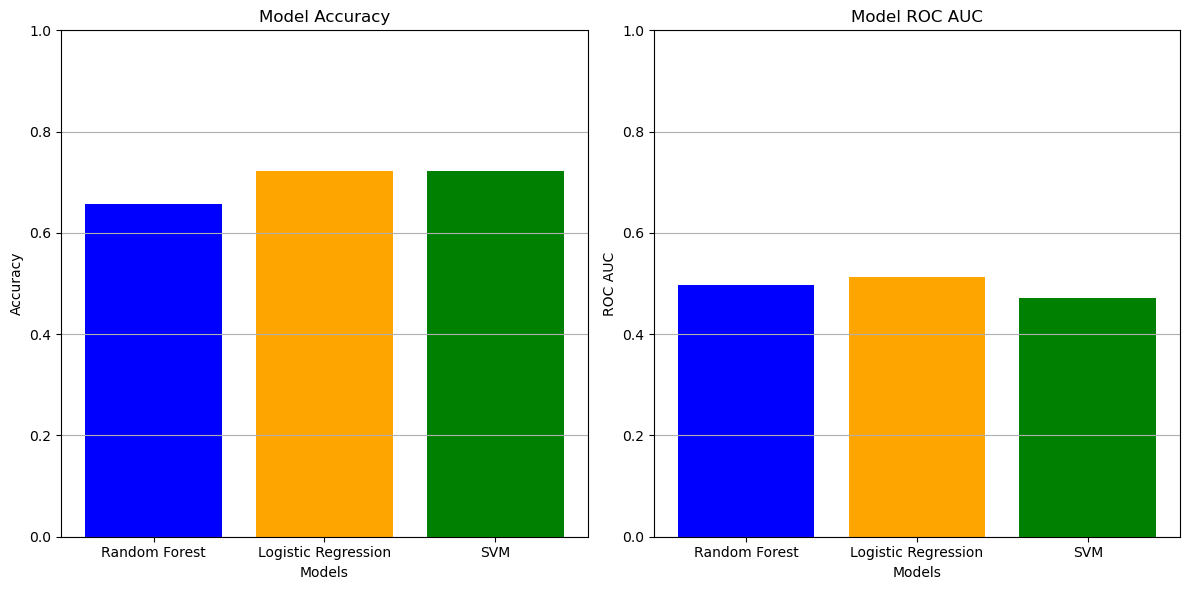

In [85]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Create subplots for Accuracy and ROC AUC
plt.subplot(1, 2, 1)
plt.bar(model_names, accuracies, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)
plt.title('Model Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.grid(axis='y')

plt.subplot(1, 2, 2)
plt.bar(model_names, roc_aucs, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)
plt.title('Model ROC AUC')
plt.xlabel('Models')
plt.ylabel('ROC AUC')
plt.grid(axis='y')

# Show the plots
plt.tight_layout()
plt.show()

In [86]:
import pandas as pd

# Create a sample data dictionary (use actual values you'd expect in the real world)
sample_data = {
    'Temperature': [22.5, 35.2, 18.9],  # Sample temperatures
    'Humidity': [50, 70, 30],           # Sample humidity levels
    'HVAC_Status': [1, 0, 1]            # 1 for ON, 0 for OFF
}

# Convert the dictionary to a DataFrame
sample_df = pd.DataFrame(sample_data)

In [87]:
# Standardize the sample data (if necessary for models like SVM)
sample_scaled = scaler.transform(sample_df)

In [88]:
# Predict using Random Forest
rf_pred = models['Random Forest'].predict(sample_df)

# Predict using Logistic Regression
lr_pred = models['Logistic Regression'].predict(sample_df)

# Predict using SVM (scaled data required for SVM)
svm_pred = models['SVM'].predict(sample_scaled)

# Print the results
print("Random Forest Predictions:", rf_pred)
print("Logistic Regression Predictions:", lr_pred)
print("SVM Predictions:", svm_pred)


Random Forest Predictions: [0 1 0]
Logistic Regression Predictions: [0 0 0]
SVM Predictions: [0 0 0]


In [89]:
import pickle

In [90]:
# Save each model
with open('random_forest_model.pkl', 'wb') as rf_file:
    pickle.dump(models['Random Forest'], rf_file)

with open('logistic_regression_model.pkl', 'wb') as lr_file:
    pickle.dump(models['Logistic Regression'], lr_file)

with open('svm_model.pkl', 'wb') as svm_file:
    pickle.dump(models['SVM'], svm_file)

In [91]:
# Load the models
with open('random_forest_model.pkl', 'rb') as rf_file:
    rf_model = pickle.load(rf_file)

with open('logistic_regression_model.pkl', 'rb') as lr_file:
    lr_model = pickle.load(lr_file)

with open('svm_model.pkl', 'rb') as svm_file:
    svm_model = pickle.load(svm_file)

In [92]:
import numpy as np

def predict_failure(model, temperature, humidity, hvac_status):
    # Prepare the input data
    sample_data = np.array([[temperature, humidity, hvac_status]])
    
    # If using SVM, scale the input data
    if isinstance(model, SVC):  # Check if it's the SVM model
        sample_data = scaler.transform(sample_data)
    
    # Make prediction
    prediction = model.predict(sample_data)
    return prediction[0]  # Return the class (0 or 1)

# Example usage
temperature = 25  # Example temperature
humidity = 50     # Example humidity
hvac_status = 1   # HVAC is ON

rf_prediction = predict_failure(rf_model, temperature, humidity, hvac_status)
lr_prediction = predict_failure(lr_model, temperature, humidity, hvac_status)
svm_prediction = predict_failure(svm_model, temperature, humidity, hvac_status)

print(f"Random Forest Prediction: {rf_prediction}")
print(f"Logistic Regression Prediction: {lr_prediction}")
print(f"SVM Prediction: {svm_prediction}")

Random Forest Prediction: 1
Logistic Regression Prediction: 0
SVM Prediction: 0


C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [93]:
# Example usage
temperature = 15.7798573604024  # Example temperature
humidity = 29.4164078916985     # Example humidity
hvac_status = 0   # HVAC is OFF

rf_prediction = predict_failure(rf_model, temperature, humidity, hvac_status)
lr_prediction = predict_failure(lr_model, temperature, humidity, hvac_status)
svm_prediction = predict_failure(svm_model, temperature, humidity, hvac_status)

print(f"Random Forest Prediction: {rf_prediction}")
print(f"Logistic Regression Prediction: {lr_prediction}")
print(f"SVM Prediction: {svm_prediction}")

Random Forest Prediction: 0
Logistic Regression Prediction: 0
SVM Prediction: 0


C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [94]:
# Example usage
temperature = 21.2108355629688  # Example temperature
humidity = 68.3691517083928     # Example humidity
hvac_status = 0   # HVAC is OFF

rf_prediction = predict_failure(rf_model, temperature, humidity, hvac_status)
lr_prediction = predict_failure(lr_model, temperature, humidity, hvac_status)
svm_prediction = predict_failure(svm_model, temperature, humidity, hvac_status)

print(f"Random Forest Prediction: {rf_prediction}")
print(f"Logistic Regression Prediction: {lr_prediction}")
print(f"SVM Prediction: {svm_prediction}")

Random Forest Prediction: 0
Logistic Regression Prediction: 0
SVM Prediction: 0


C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [95]:
# Example usage
temperature = 21.1807411280719  # Example temperature
humidity = 41.8814935141343     # Example humidity
hvac_status = 0   # HVAC is OFF

rf_prediction = predict_failure(rf_model, temperature, humidity, hvac_status)
lr_prediction = predict_failure(lr_model, temperature, humidity, hvac_status)
svm_prediction = predict_failure(svm_model, temperature, humidity, hvac_status)

print(f"Random Forest Prediction: {rf_prediction}")
print(f"Logistic Regression Prediction: {lr_prediction}")
print(f"SVM Prediction: {svm_prediction}")

Random Forest Prediction: 1
Logistic Regression Prediction: 0
SVM Prediction: 0


C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
